# RK-4 Scheme

The time taken to compute 20 timesteps is: 2.7899



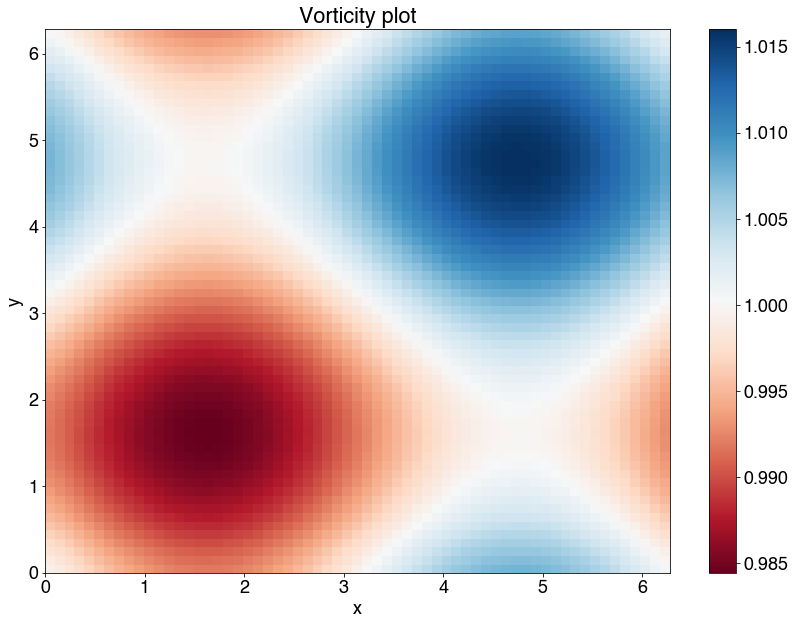

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import searchsorted, array, real, where
from numpy.fft import fft2, ifft2
from time import time
from bisect import bisect_right
import csv

font = {'family' : 'helvetica','size'   : 18}
plt.rc('font', **font) 

# script for shallow water eq with RK4
nu = 8e-8  # viscosity
# cor = 1000  # Coriolis parameter
# cor = 50
cor = 50
g = 10  # gravity
HH = 6.5  # mean height
Nx = 64 # note usually 32, 64 gives interesting stuff
Ny = 64

# dt = 0.0001
# dt = 0.001 # smaller timestep
dt = 0.005

# NOTE: For every T=10 runtime is approx. 1 minute 
# Tend = 30 # original Tend = 1
# Tend = 120
Tend = .1
Nt = int(Tend/dt)

# # interval length
# x_end = 2*np.pi
# x_start = -x_end
# y_end = 2*np.pi
# y_start = -y_end

# interval length
x_end = 2*np.pi
x_start = 0
y_end = 2*np.pi
y_start = 0

# grid dimensions
x_vec, dx = np.linspace(x_start, x_end, Nx, retstep=True)
y_vec, dy = np.linspace(y_start, y_end, Ny, retstep=True)

# create grid
xx, yy = np.meshgrid(x_vec, y_vec)

Kx = np.zeros(Nx)
Kx[:int(Nx / 2)] = np.arange(int(Nx / 2))
Kx[int(Nx / 2):] = np.arange(-int(Nx / 2), 0)
Ky = Kx
Kxx, Kyy = np.meshgrid(Kx, Ky)
k2poisson = Kxx**2+Kyy**2

RHSz_mat = np.zeros((Nx, Ny, 3), dtype=complex)
zkCor = np.zeros((Nx, Ny, 3), dtype=complex)

# de-aliasing mask: forces the nonlinear terms for kx,ky>2/3 to be zero
# depending on the problem and the type of dissipation can be relaxed ...
L = np.ones(np.shape(k2poisson))
for i in range(Nx):
    for j in range(Ny):
        if abs(Kxx[j, i]) > max(Kx)*2./3.:
            L[j, i] = 0
        elif abs(Kyy[j, i]) > max(Ky)*2./3.:
            L[j, i] = 0

# wave solution IC
# UU = 0.01
# kw = 2
# omeg = np.sqrt(cor**2+g*HH*kw**2)
# urr = UU*np.cos(kw*xx)
# vrr = cor/omeg*UU*np.sin(kw*xx)
# hrr = HH*kw/omeg*UU*np.cos(kw*xx)
# hk = fft2(hrr)
# uk = fft2(urr)
# vk = fft2(vrr)
# zk = 1j*Kxx*vk-1j*Kyy*uk

# waves to be added ontop
# UU = 0.01 # original
UU = 0.01
kw = 2 # original
# kw = 3
omeg = np.sqrt(cor**2+g*HH*kw**2)
ur_w =  UU*np.cos(kw*xx)
vr_w =  cor/omeg*UU*np.sin(kw*xx)
hr_w =  HH*kw/omeg*UU*np.cos(kw*xx)

# I.Cs
urr = -UU*np.cos(yy) + ur_w
vrr = UU*np.cos(xx) + vr_w
hrr = cor/g * UU * (np.sin(xx)+np.sin(yy)) + hr_w
hk = fft2(hrr)
uk = fft2(urr)
vk = fft2(vrr)

Cc1 = np.exp(-dt*nu*k2poisson**4)
Cc = np.zeros((Nx, Nx, 3))
Cc[:, :, 0] = Cc[:, :, 1] = Cc[:, :, 2] = Cc1

# vorticity in fourier space
zkCor[:, :, 0] = hk

# components of velocity in fourier space
zkCor[:, :, 1] = uk
zkCor[:, :, 2] = vk

# def error_norm(uu, vv, uu_exact, vv_exact):
#     eu = uu - uu_exact
#     ev = vv - vv_exact
#     return np.sqrt(np.sum(eu**2+ev**2))*np.sqrt(dx*dy)

# # define initial particle position based on meshgrid:
x_pos = np.copy(xx)
y_pos = np.copy(yy)

# list to store particle position at each timestep, should I add intitial position to this??
x_traj_store = []
y_traj_store = []
u_field_store = []
v_field_store = []
h_field_store = []


def RHS_momentum(uvhk):
    # init array
    RHS = np.zeros((Nx, Ny, 3), dtype=complex)

    # retrieve valies from input and inverse fourier transform
    hr = real(ifft2(uvhk[:, :, 0]))
    ur = real(ifft2(uvhk[:, :, 1]))
    vr = real(ifft2(uvhk[:, :, 2]))

    # inverse fourier transform
    u_xr = real(ifft2(1j*Kxx*uvhk[:, :, 1]))
    v_xr = real(ifft2(1j*Kxx*uvhk[:, :, 2]))
    u_yr = real(ifft2(1j*Kyy*uvhk[:, :, 1]))
    v_yr = real(ifft2(1j*Kyy*uvhk[:, :, 2]))

    # de-aliasing mask, forcing non-linear terms to be 0
    Nhx = L*fft2(ur*(hr + HH))
    Nhy = L*fft2(vr*(hr + HH))
    Nu = L*fft2(ur*u_xr+vr*u_yr)
    Nv = L*fft2(ur*v_xr+vr*v_yr)

    RHS[:, :, 0] = -1j * Kxx * Nhx - 1j * Kyy * Nhy
    RHS[:, :, 1] = -Nu + cor * uvhk[:, :, 2] - g * 1j * Kxx * uvhk[:, :, 0]
    RHS[:, :, 2] = -Nv - cor * uvhk[:, :, 1] - g * 1j * Kyy * uvhk[:, :, 0]

    return RHS, hr, ur, vr

def bilinear_interp_periodic(x_1d, y_1d, zz, x_wanted, y_wanted):
    '''
    Hossein's interpolation function:
    x_1d, y_1d (1darray): row and columns respectively of regularly spaced grid - each is a 1d array
    zz (2d array): values to be interpolated
    x_wanted, y_wanted: array of particle positions we want to interpolate
    '''
    init_shape = np.shape(x_wanted)
    x_wanted = x_wanted.flatten()
    y_wanted = y_wanted.flatten()
    z_wanted = np.zeros_like(x_wanted)

#     x_max = np.max(x_1d)
#     x_min = np.min(x_1d)
#     y_max = np.max(y_1d)
#     y_min = np.min(y_1d)

#     x_interval = x_max - x_min
#     y_interval = y_max - y_min

    for i_xy in range(0, np.size(x_wanted)):
        x = x_wanted[i_xy]
        y = y_wanted[i_xy]

        # this might be redundant and actually causing errors in the general case?
        # x = x - np.floor(x/x_interval)*(x_interval)
        # y = y - np.floor(y/(y_interval))*(y_interval)

#         i_2x = searchsorted(x_1d, x)
#         i_2y = searchsorted(y_1d, y)
        
        i_2x = bisect_right(x_1d, x)
        i_2y = bisect_right(y_1d, y)
        i_1x = i_2x - 1
        i_1y = i_2y - 1

        FF = array([[zz[i_1y, i_1x], zz[i_2y, i_1x]],
                       [zz[i_1y, i_2x], zz[i_2y, i_2x]]])
        z_wanted[i_xy] = 1/((x_1d[i_2x]-x_1d[i_1x])*(y_1d[i_2y]-y_1d[i_1y]))*(
            array([x_1d[i_2x] - x, x - x_1d[i_1x]])@FF@
            array([[y_1d[i_2y] - y], [y - y_1d[i_1y]]]))
        
    return np.reshape(z_wanted, init_shape)

def domain_check2(x,y, x_grid, y_grid):
    '''
    Function to get particle position in 'original' domain
    faster and assumes that we do not get more than 1 domain length away from the domain in 1 timestep
    '''

    # get max and min values
    x_max = x_grid[-1]
    x_min = x_grid[0]
    y_max = y_grid[-1]
    y_min = y_grid[0]

    # intervals
    x_int = x_max - x_min
    y_int = y_max - y_min

    # get x coords in original domain
    new_x = where(x >= x_max, x - x_int, x)
    new_x = where(new_x < x_min, new_x + x_int, new_x)

    # get y coords in original domain
    new_y = where(y >= y_max, y - y_int, y)
    new_y = where(new_y < y_min, new_y + y_int, new_y)

    return new_x, new_y

# set resolution
res = 5

# initial run time
start = time()

# looping through timesteps
for iTime in range(0, Nt):
    t = iTime * dt

    # RK 4 method
    # note: velocity field is that of the previous timestep
    KK1z, hh_prev_step, uu_prev_step, vv_prev_step = RHS_momentum(zkCor)
    KK2z, _, _, _ = RHS_momentum(zkCor + KK1z*(dt/2))
    KK3z, _, _, _  = RHS_momentum(zkCor + KK2z*(dt/2))
    KK4z, _, _, _  = RHS_momentum(zkCor + KK3z*dt)
    zkCor = zkCor * Cc + (dt/6)*(KK1z + 2*KK2z + 2*KK3z + KK4z)

#     # retrieve fourier variables
#     hk = zkCor[:, :, 0]
#     uk = zkCor[:, :, 1]
#     vk = zkCor[:, :, 2]

#     # inverse fft above variables

#     # hh = np.real(ifft2(hk))
#     uu = np.real(ifft2(uk))
#     vv = np.real(ifft2(vk))

    # get poisitons of particles in terms of periodic domain
    x_pos_in_domain, y_pos_in_domain = domain_check2(x_pos, y_pos, x_vec, y_vec)

    # retrieve horiontal and vertical velocities
    u_vals = bilinear_interp_periodic(x_vec, y_vec, uu_prev_step, x_pos_in_domain, y_pos_in_domain)
    v_vals = bilinear_interp_periodic(x_vec, y_vec, vv_prev_step, x_pos_in_domain, y_pos_in_domain)

    # advect particle positions
    x_pos += u_vals*dt
    y_pos += v_vals*dt

    if iTime%res == 0:

        # add particle trajectory to list - errors without np.copy
        x_traj_store.append(np.copy(x_pos))
        y_traj_store.append(np.copy(y_pos))

        u_field_store.append(np.copy(uu_prev_step))
        v_field_store.append(np.copy(vv_prev_step))
        h_field_store.append(np.copy(hh_prev_step))


# time RK 4 is finished
end = time()

# time taken
time_diff = end - start

# print time taken
print(f'The time taken to compute {Nt} timesteps is: {np.round(time_diff, 4)}\n')

hk = zkCor[:, :, 0]
uk = zkCor[:, :, 1]
vk = zkCor[:, :, 2]

# inverse fft above variables

hh = np.real(ifft2(hk))
uu = np.real(ifft2(uk))
vv = np.real(ifft2(vk))
zr = np.real(ifft2(1j*Kxx*vk-1j*Kyy*uk))
plot = (zr/cor+1.)/(hh/HH+1.)

# plotting
fig = plt.figure(figsize=(14,10))
axs = plt.axes()
c = axs.pcolor(xx, yy, plot, cmap='RdBu')
fig.colorbar(c, ax=axs)
axs.set_title('Vorticity plot')
axs.set_xlabel('x')
axs.set_ylabel('y')

plt.show()

# # check if folder exists, if not create it - permissions error
# if not os.path.exists('/outputs'):
#     os.mknod('/outputs')

# # save - to folder
# np.save('outputs/x_trajs', np.array(x_traj_store))
# np.save('outputs/y_trajs', np.array(y_traj_store))
# np.save('outputs/u_fields', np.array(u_field_store))
# np.save('outputs/v_fields', np.array(v_field_store))
# np.save('outputs/h_fields', np.array(h_field_store))

# save to file
np.save('x_trajs', np.array(x_traj_store))
np.save('y_trajs', np.array(y_traj_store))
np.save('u_fields', np.array(u_field_store))
np.save('v_fields', np.array(v_field_store))
np.save('h_fields', np.array(h_field_store))

In [8]:
t1 = time()
test = np.load('outputs/x_trajs.npy')
t2 = time()

print(f'Time taken to load: {t2-t1}')

Time taken to load: 0.008476018905639648


In [16]:
param_dict = {'UU': UU,
              'x_start': x_start,
              'x_end': x_end,
              'y_start': y_start,
              'y_end': y_end,
              'coriolis': cor,
              'dt': dt,
              'dx': dx,
              'mean height': HH,
              'Nx, Ny': (Nx, Ny),
              'End time': Tend,
              'No timestep': Nt,
              'omega': omeg}

import csv


with open('params.csv', 'w') as f:  # You will need 'wb' mode in Python 2.x
    w = csv.DictWriter(f, param_dict.keys())
    w.writeheader()
    w.writerow(param_dict)

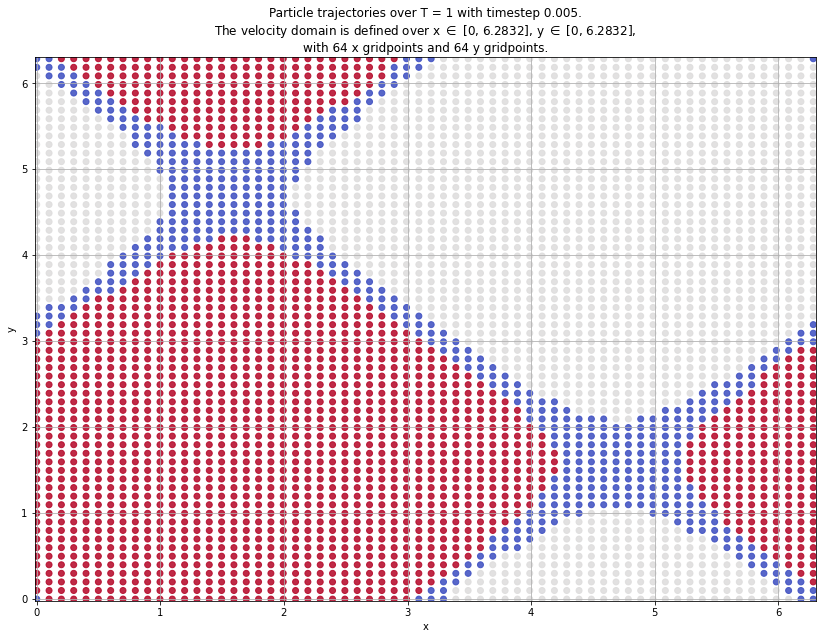

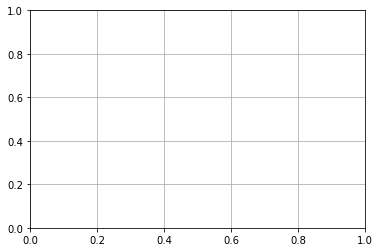

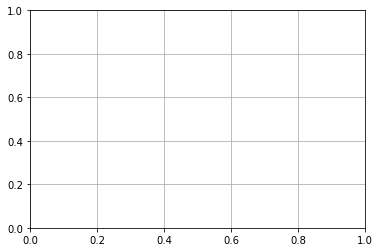

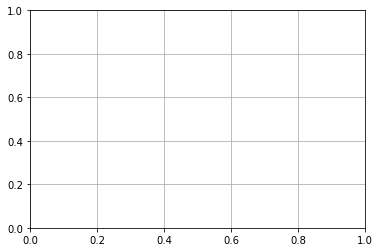

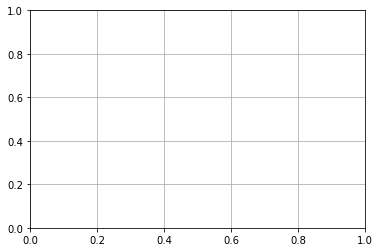

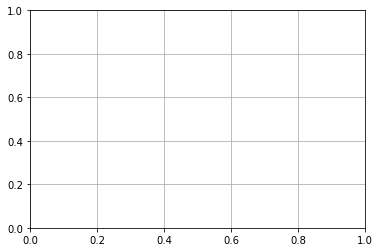

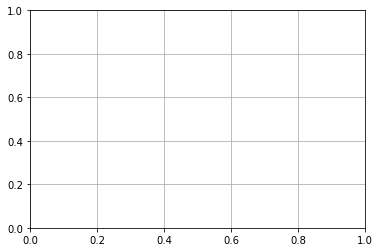

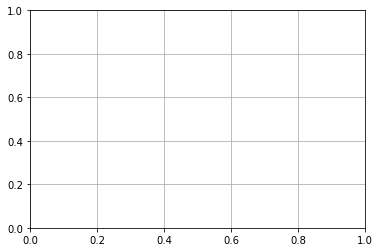

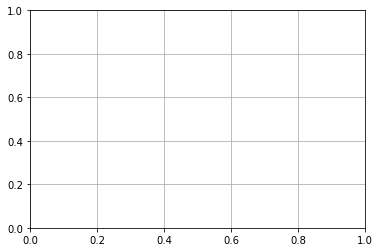

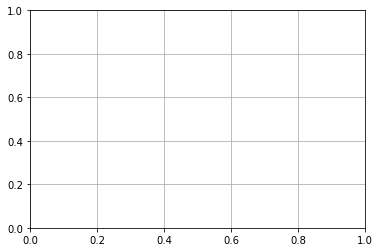

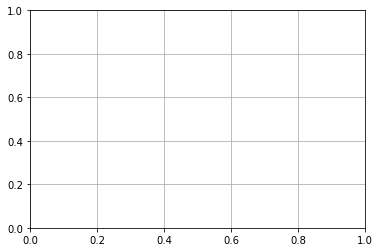

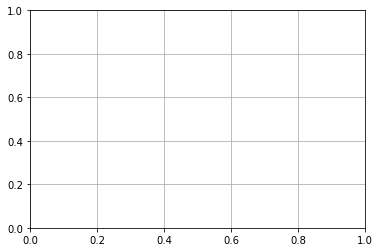

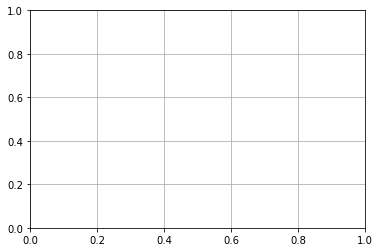

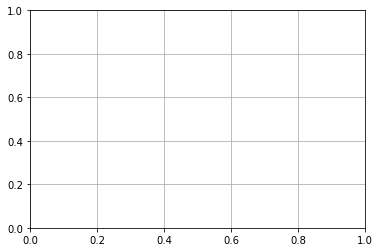

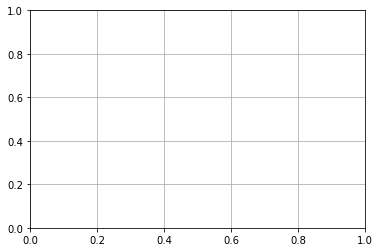

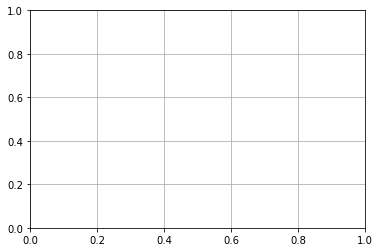

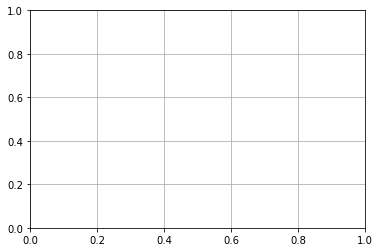

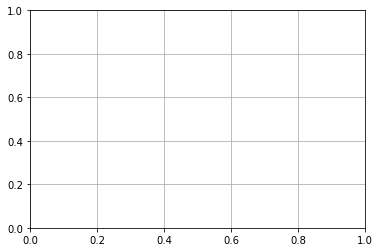

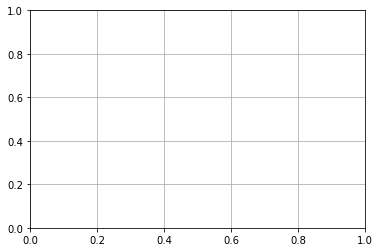

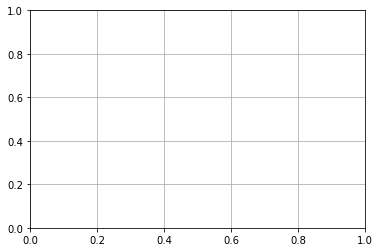

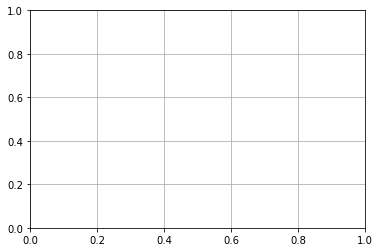

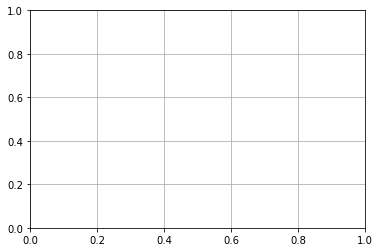

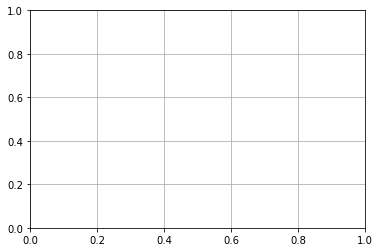

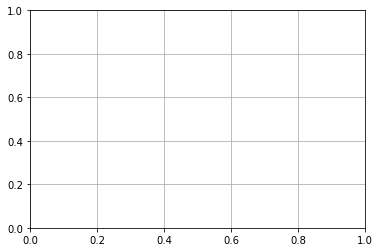

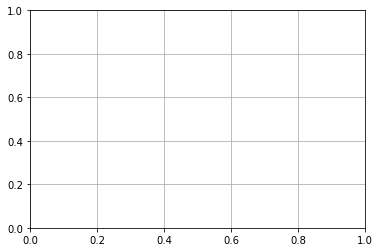

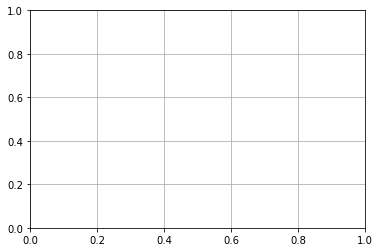

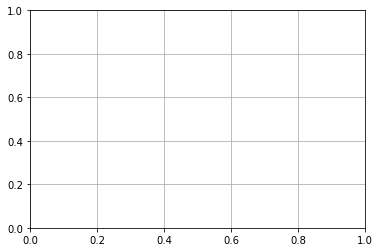

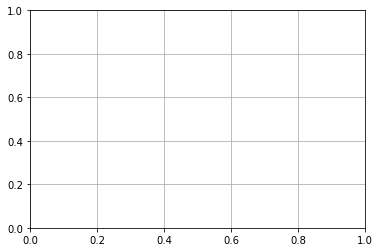

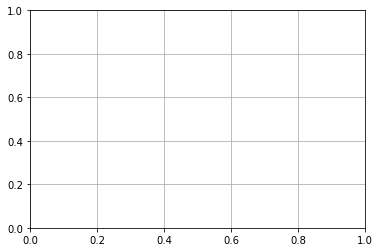

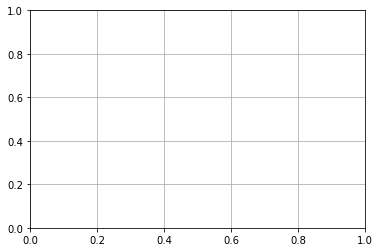

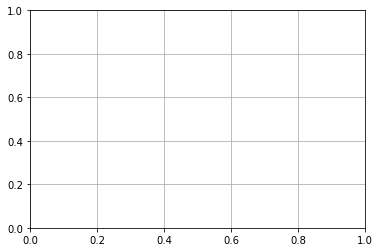

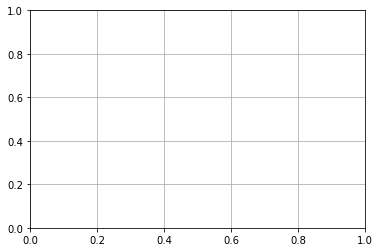

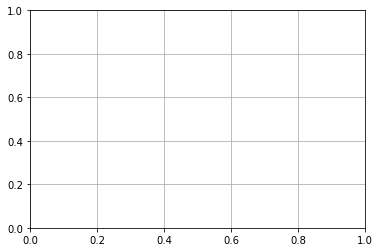

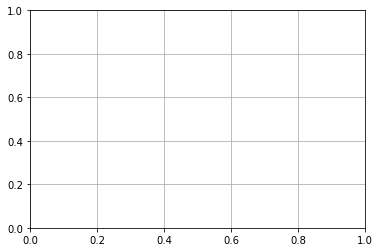

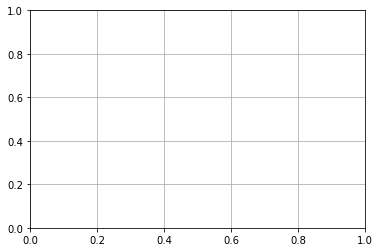

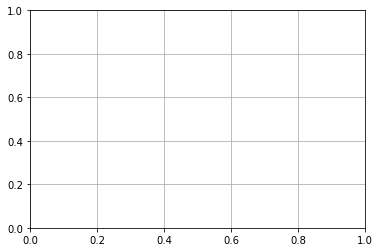

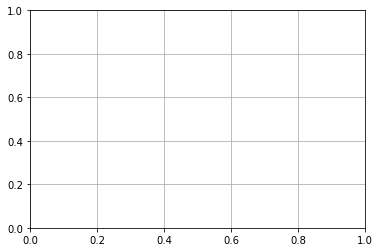

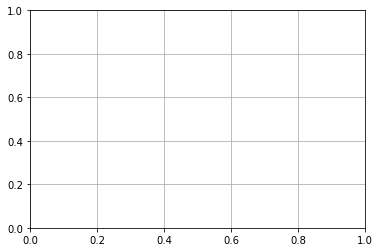

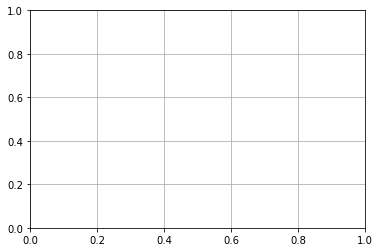

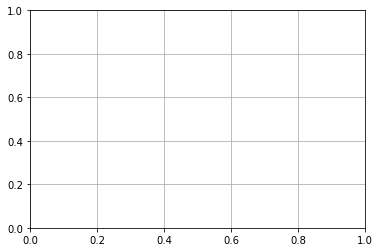

In [21]:
# This library can be installed through - pip install celluloid
from celluloid import Camera

# init array
colour_label = np.zeros_like(plot)

# set values based on vorticity of fluid
colour_label = np.where(plot > 1.002, 1, 0) # 1.002
ind_2 = np.where(plot<0.998) # 0.998
colour_label[ind_2] = 2

# create figure object
fig = plt.figure(figsize=(14,10))
# load axis box
ax = plt.axes()
# set axis limit
ax.set_ylim(np.min(y_traj_store), np.max(y_traj_store))
ax.set_xlim(np.min(x_traj_store), np.max(x_traj_store))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'Particle trajectories over T = {Tend} with timestep {dt}.\n'
             + f'The velocity domain is defined over x $\in$ [{np.round(x_start, 4)}, {np.round(x_end, 4)}], '
             + f'y $\in$ [{np.round(y_start, 4)}, {np.round(y_end, 4)}],\n'
             + f'with {Nx} x gridpoints and {Ny} y gridpoints.')

# getting colour for each individual particle
if len(x_pos) > 1:
    # colour array
    no_colour = x_traj_store[0].flatten().shape[0]
    colour = np.arange(no_colour)
else:
    colour = [0]

# generating gif
camera = Camera(fig)
for i in range(len(x_traj_store)):
    ax.scatter(x_traj_store[i], y_traj_store[i], cmap='coolwarm', alpha=0.85,
               c=colour_label.flatten()) #color = ['r', 'm', 'b', 'c', 'k'])
    plt.grid()
    plt.pause(0.001)
    camera.snap()

# saving gif
animation = camera.animate()
animation.save('particle_trajectory.gif', writer='pillow', fps=30)

In [13]:
# loading and testing 
x_traj_test = np.load('./eddie_results_store/eddie_files_result4/x_trajs.npy')
y_traj_test = np.load('./eddie_results_store/eddie_files_result4/y_trajs.npy')
h_result = np.load('./eddie_results_store/eddie_files_result4/h_fields.npy')
u_result = np.load('./eddie_results_store/eddie_files_result4/u_fields.npy')
v_result = np.load('./eddie_results_store/eddie_files_result4/v_fields.npy')

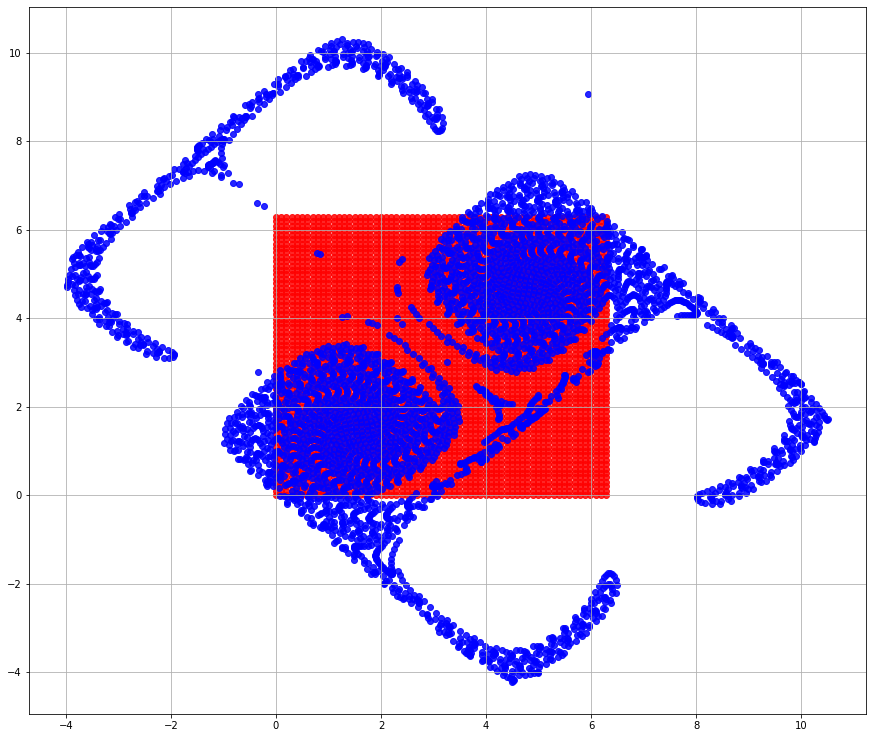

In [14]:
x_end_pos = x_traj_test[-1]
y_end_pos = y_traj_test[-1]

x_start_pos = x_traj_test[0]
y_start_pos = y_traj_test[0]

plt.figure(figsize=(15,13))
plt.scatter(x_start_pos, y_start_pos, c='r', alpha=0.85, label='initial position')
plt.scatter(x_end_pos, y_end_pos, c='b', alpha=0.85, label='final position')
plt.grid()
plt.show()

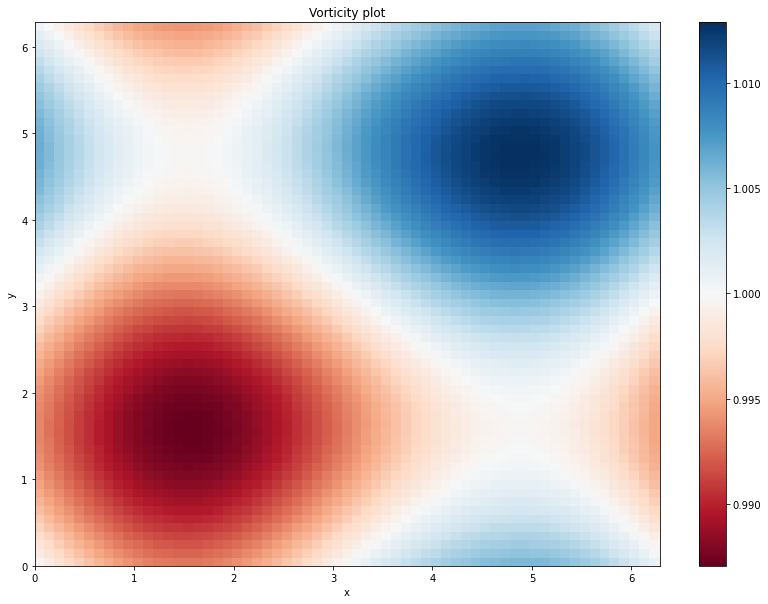

In [15]:
hh = h_result[-1]
uu = u_result[-1]
vv = v_result[-1]
zr = np.real(ifft2(1j*Kxx*fft2(vv)-1j*Kyy*fft2(uu)))
plot = (zr/cor+1.)/(hh/HH+1.)

# plotting
fig = plt.figure(figsize=(14,10))
axs = plt.axes()
c = axs.pcolor(xx, yy, plot, cmap='RdBu')
fig.colorbar(c, ax=axs)
axs.set_title('Vorticity plot')
axs.set_xlabel('x')
axs.set_ylabel('y')

plt.show()

In [12]:
x_traj_test.shape

(24000, 64, 64)

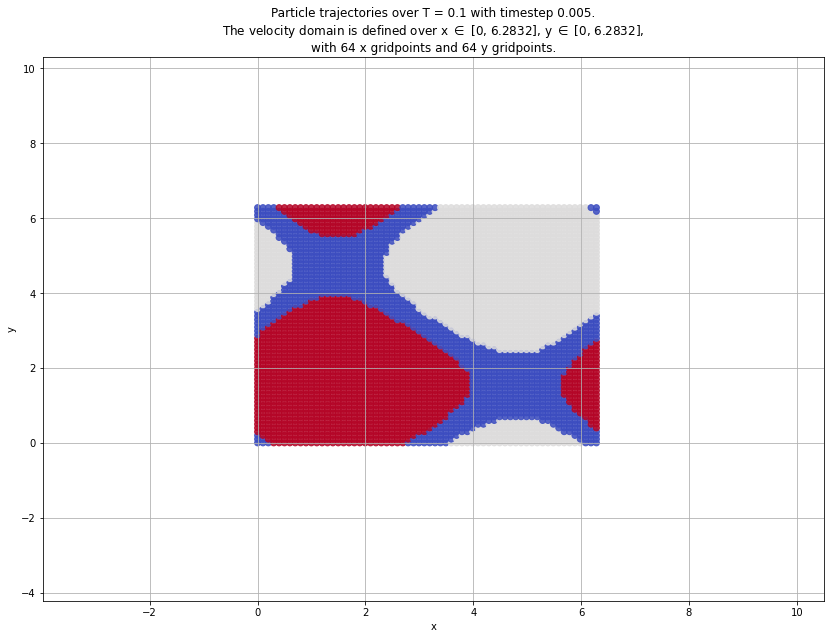

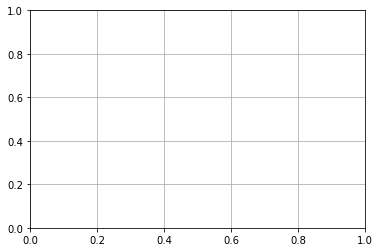

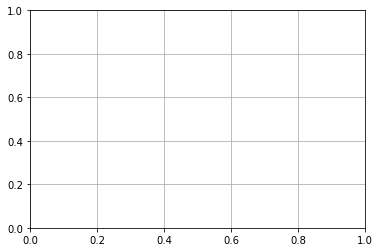

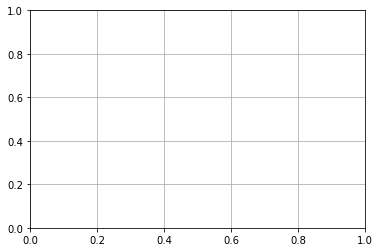

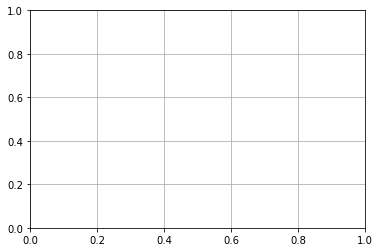

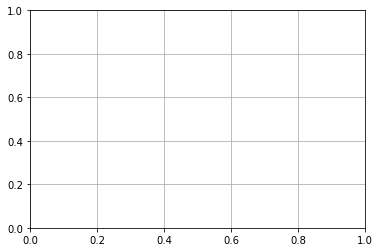

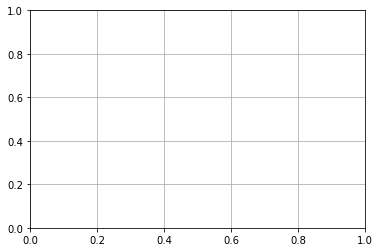

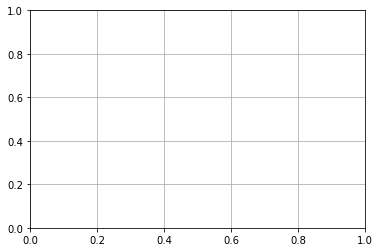

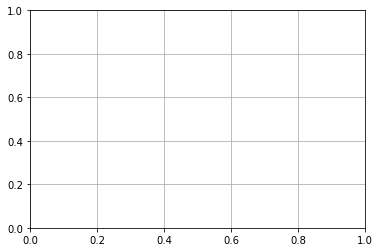

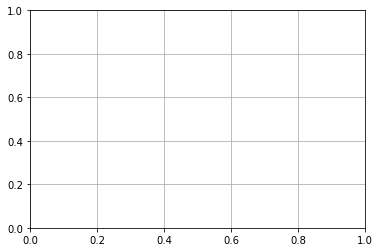

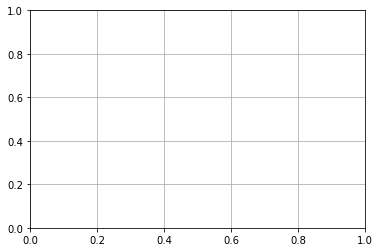

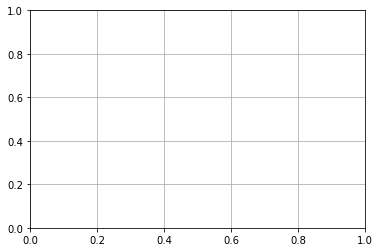

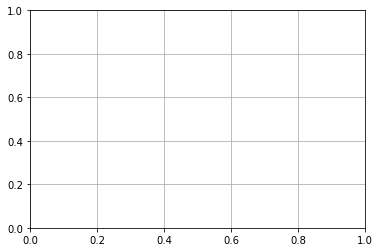

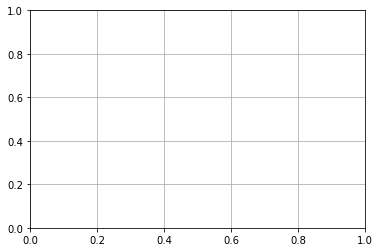

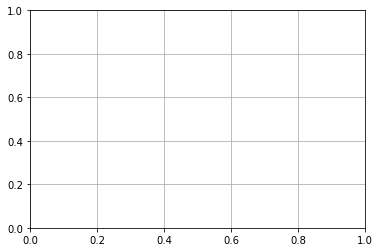

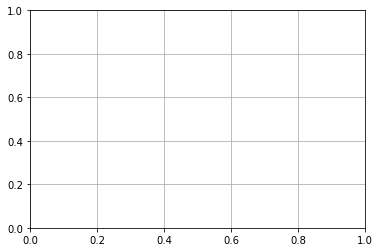

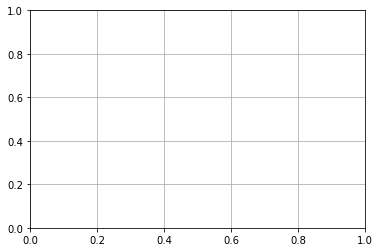

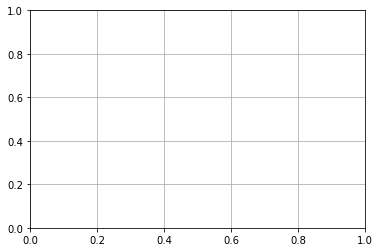

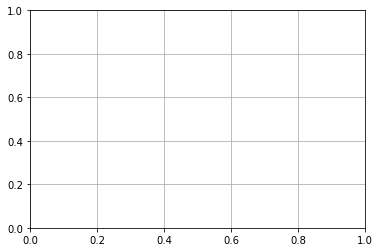

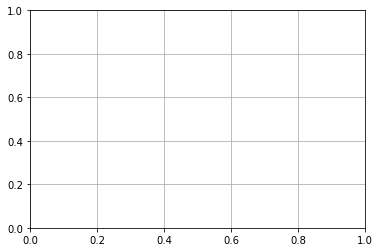

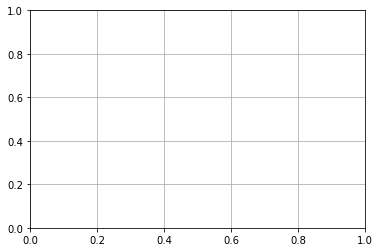

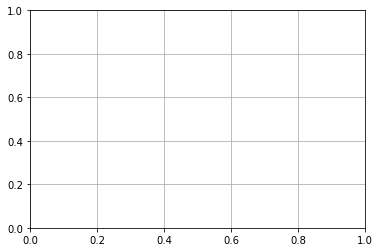

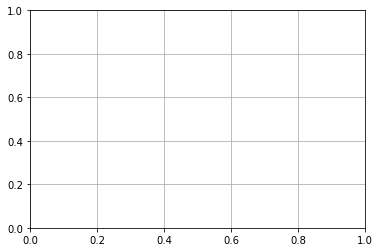

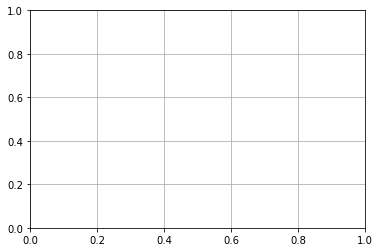

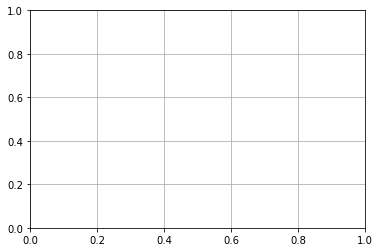

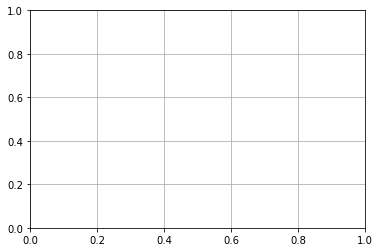

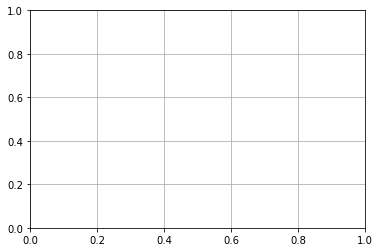

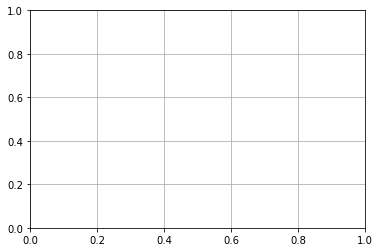

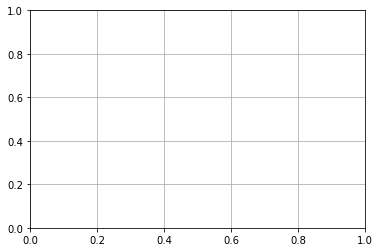

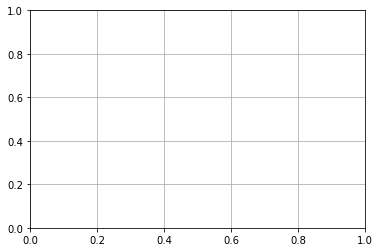

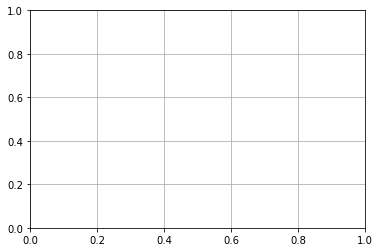

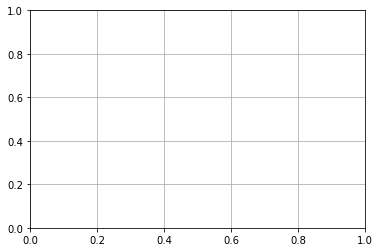

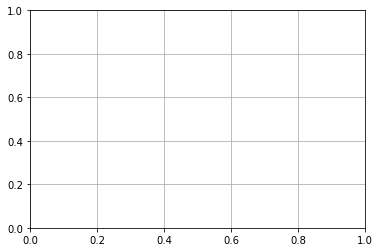

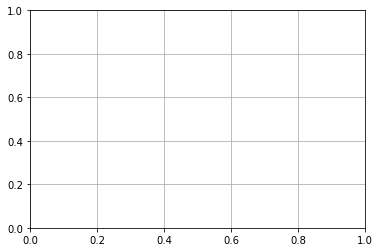

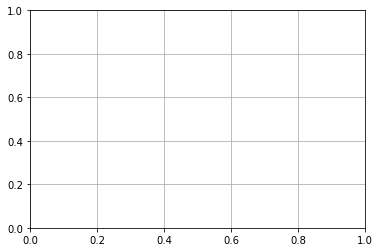

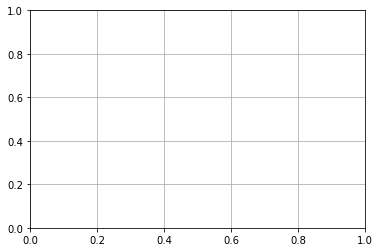

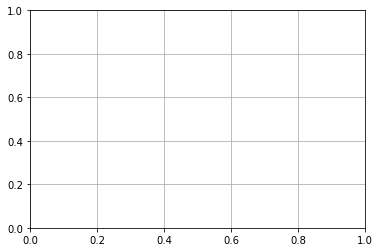

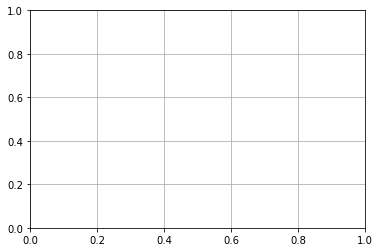

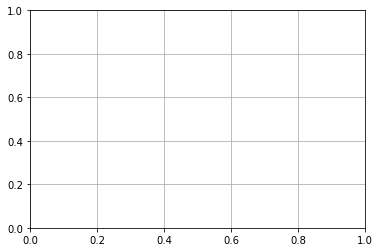

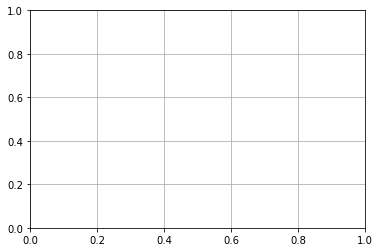

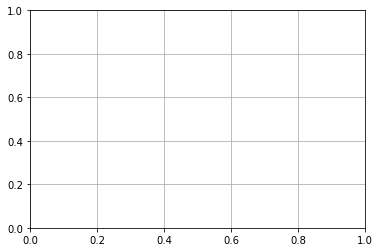

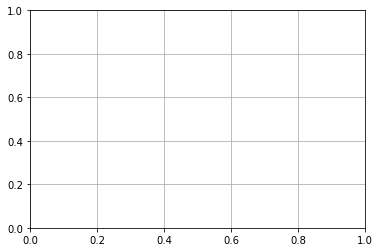

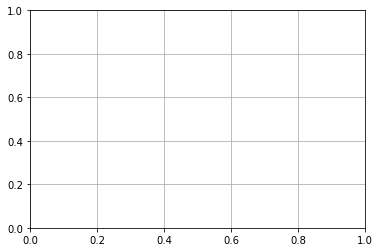

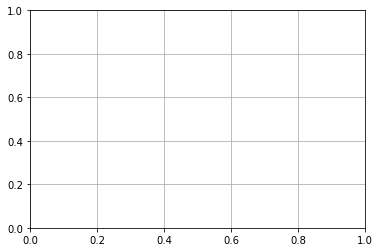

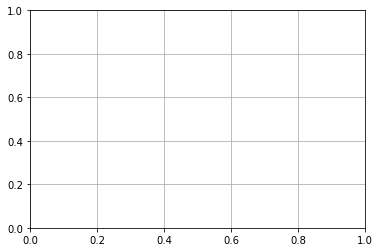

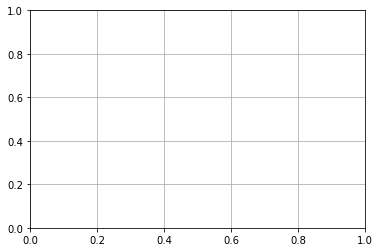

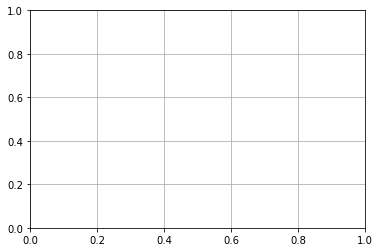

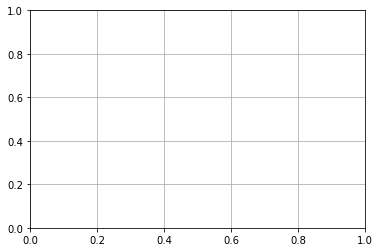

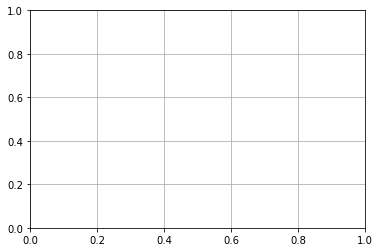

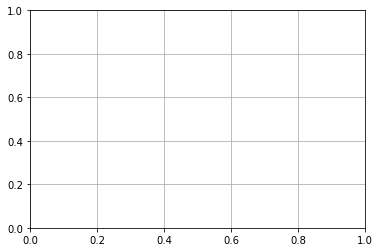

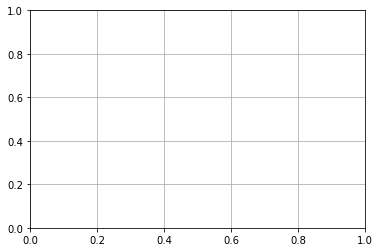

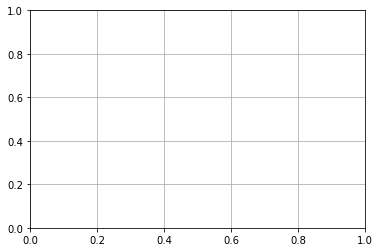

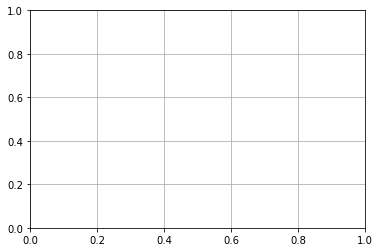

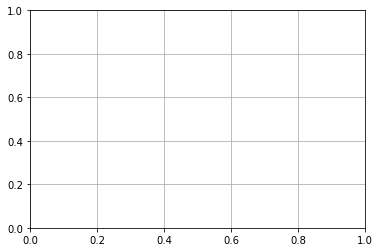

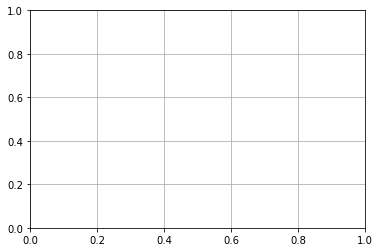

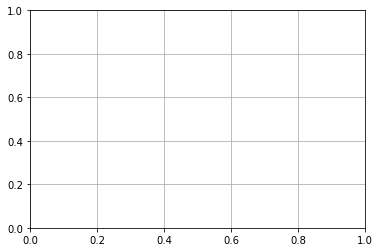

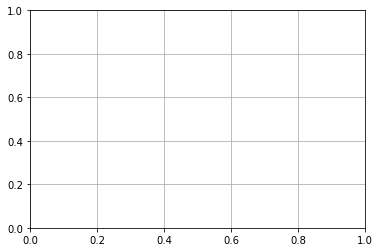

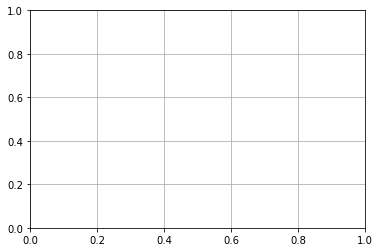

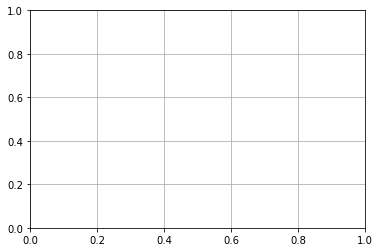

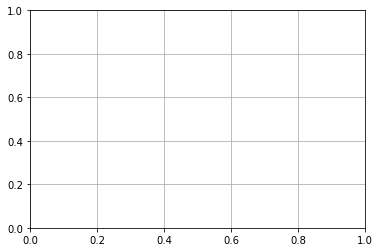

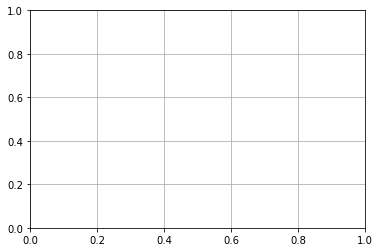

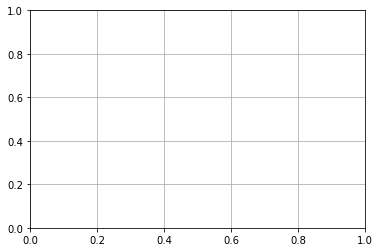

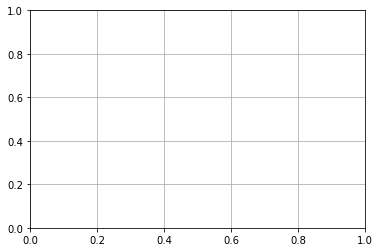

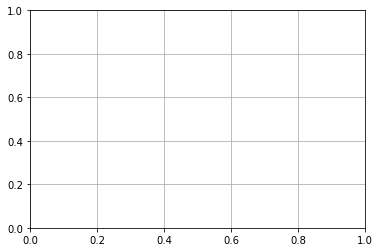

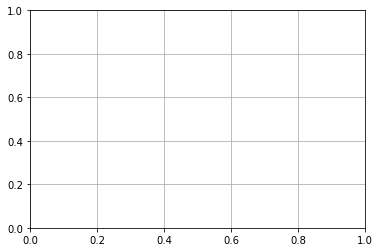

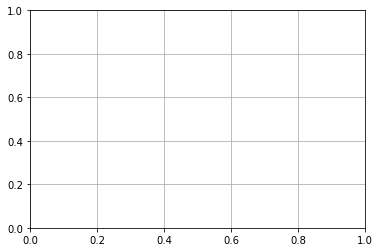

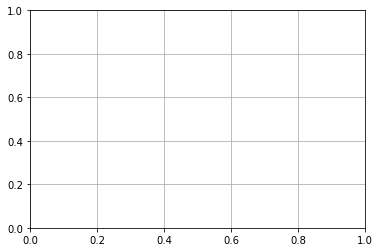

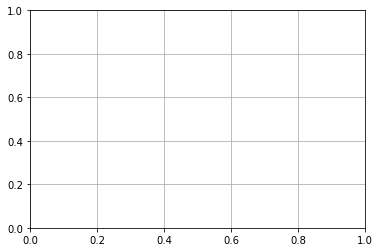

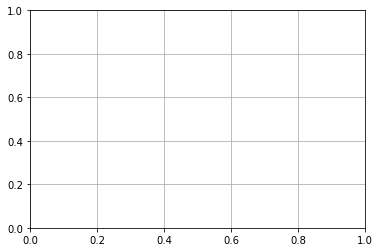

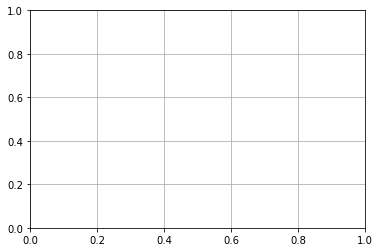

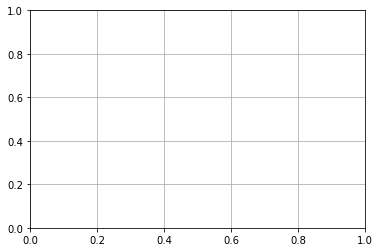

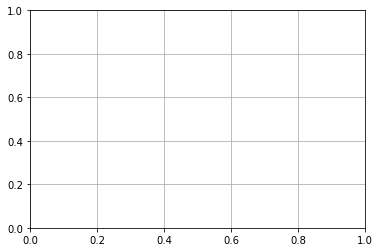

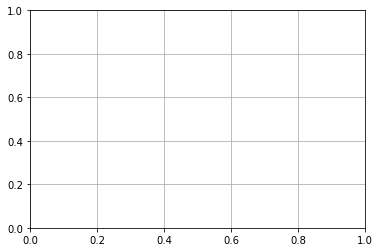

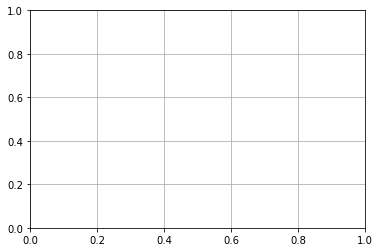

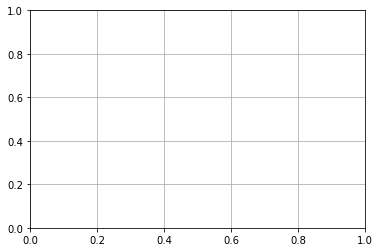

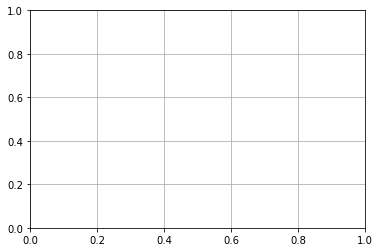

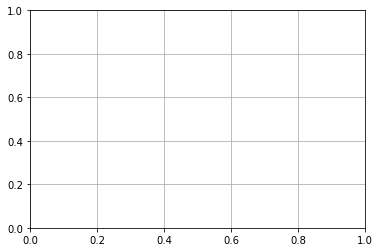

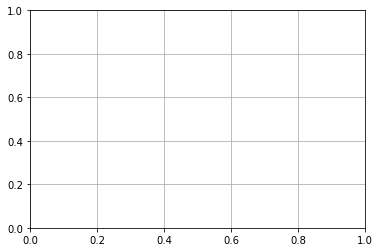

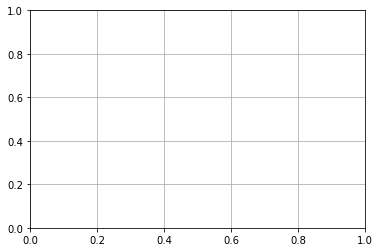

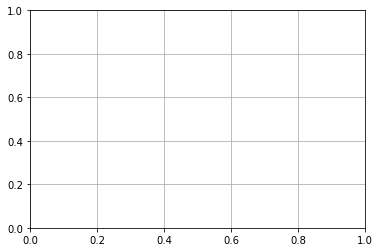

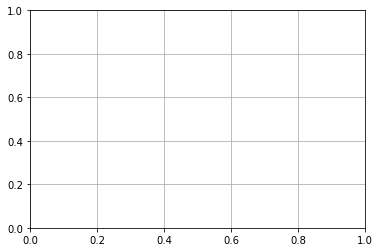

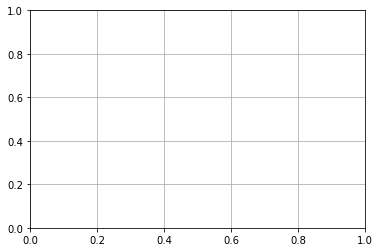

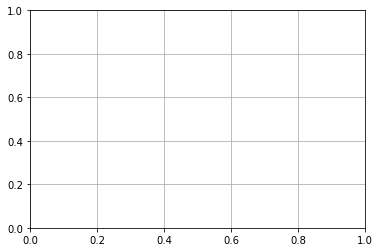

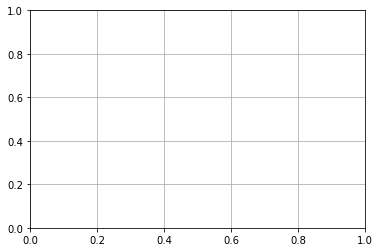

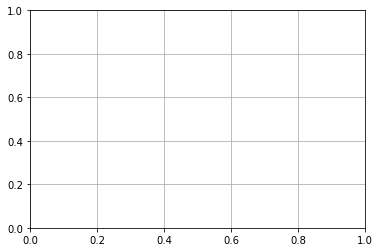

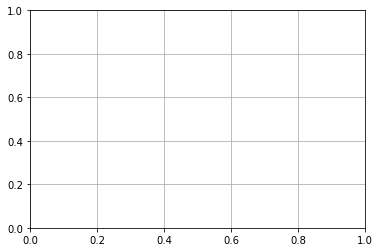

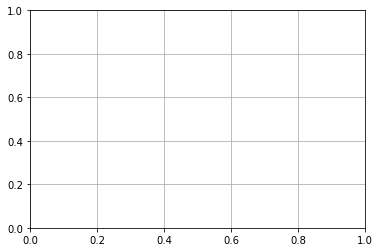

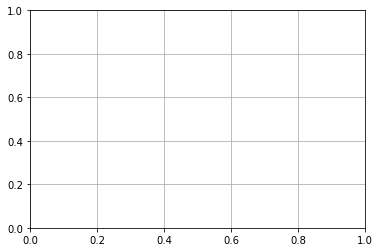

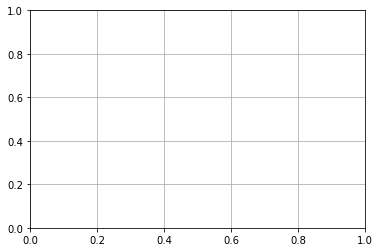

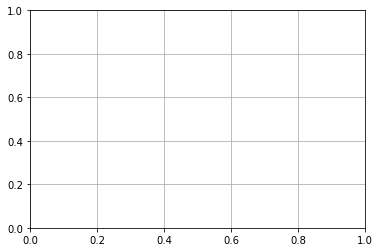

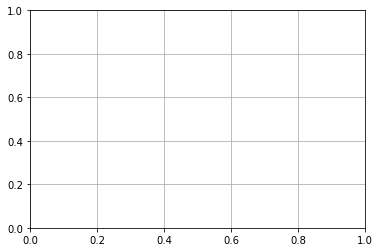

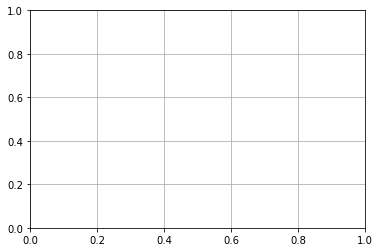

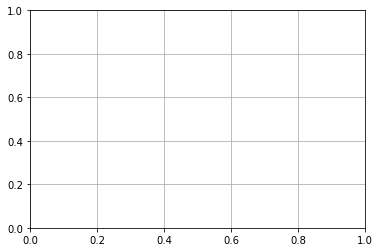

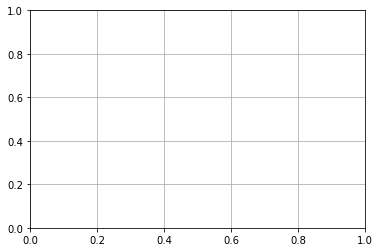

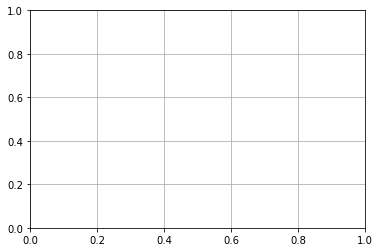

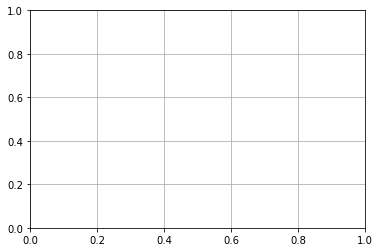

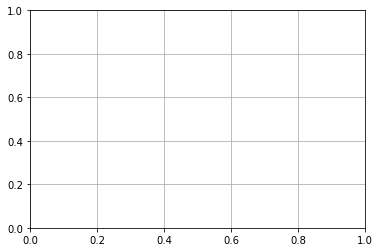

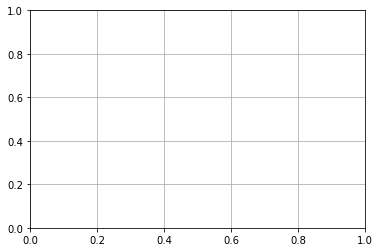

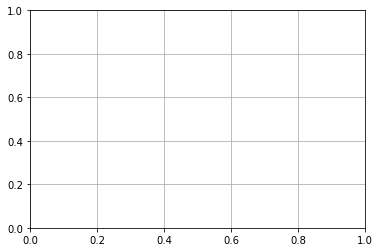

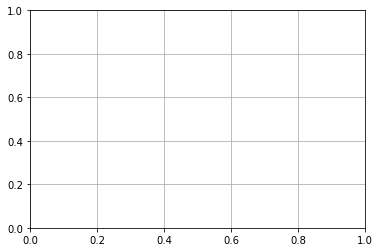

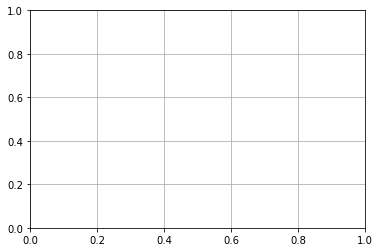

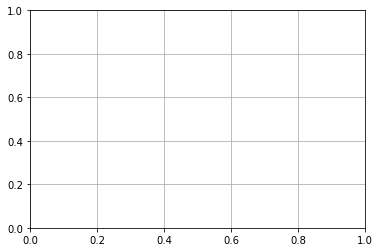

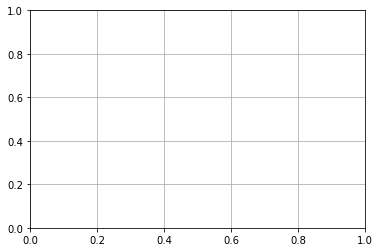

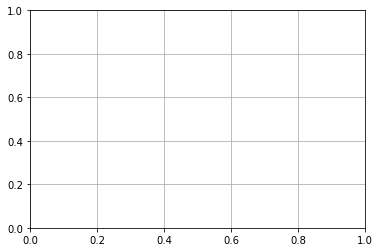

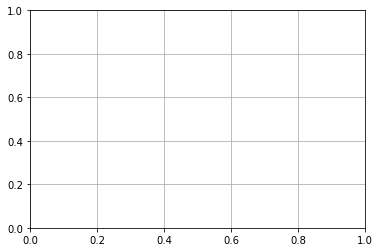

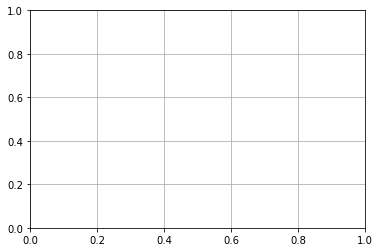

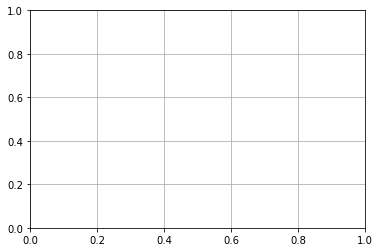

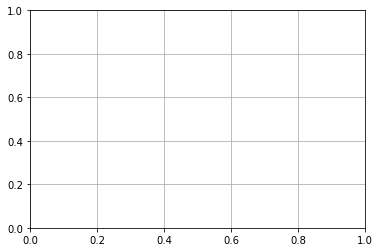

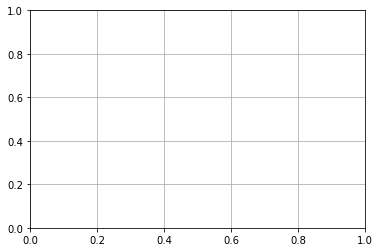

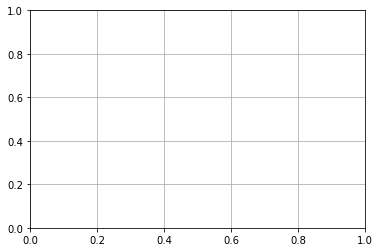

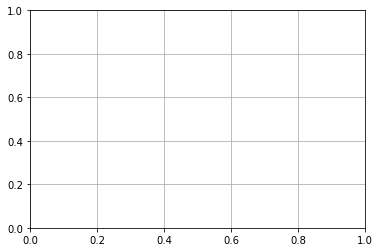

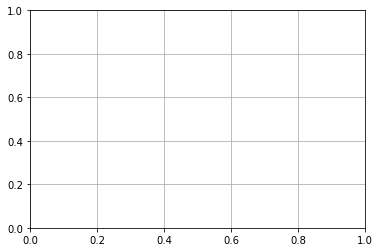

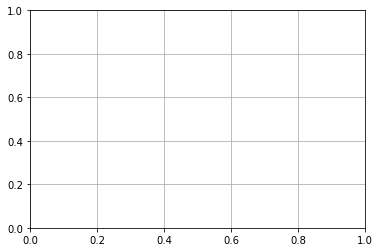

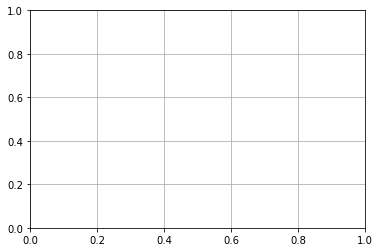

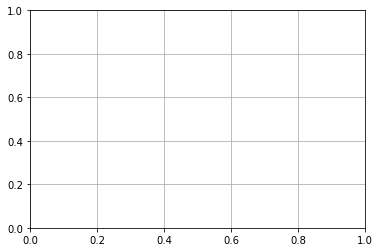

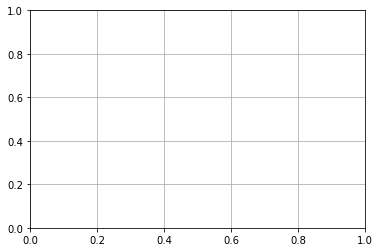

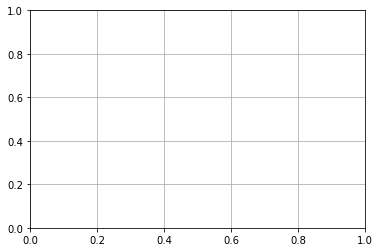

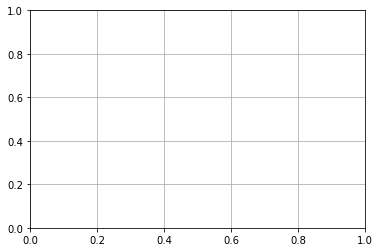

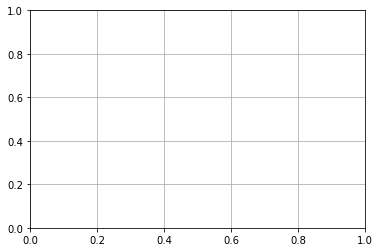

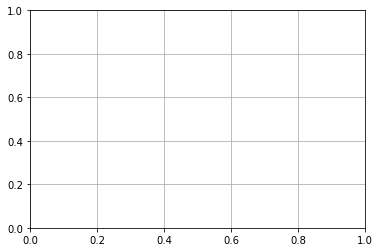

In [16]:
from celluloid import Camera

# init array
colour_label = np.zeros_like(plot)

# set values based on vorticity of fluid
colour_label = np.where(plot > 1.002, 1, 0) # 1.002
ind_2 = np.where(plot<0.998) # 0.998
colour_label[ind_2] = 2

# create figure object
fig = plt.figure(figsize=(14,10))
# load axis box
ax = plt.axes()
# set axis limit
ax.set_ylim(np.min(y_traj_test), np.max(y_traj_test))
ax.set_xlim(np.min(x_traj_test), np.max(x_traj_test))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'Particle trajectories over T = {Tend} with timestep {dt}.\n'
             + f'The velocity domain is defined over x $\in$ [{np.round(x_start, 4)}, {np.round(x_end, 4)}], '
             + f'y $\in$ [{np.round(y_start, 4)}, {np.round(y_end, 4)}],\n'
             + f'with {Nx} x gridpoints and {Ny} y gridpoints.')

# getting colour for each individual particle
if len(x_pos) > 1:
    # colour array
    no_colour = x_traj_test[0].flatten().shape[0]
    colour = np.arange(no_colour)
else:
    colour = [0]

# generating gif
camera = Camera(fig)
for i in range(0, len(x_traj_test), 200):
    ax.scatter(x_traj_test[i], y_traj_test[i], cmap='coolwarm', alpha=0.85, 
               c=colour_label.flatten()) #color = ['r', 'm', 'b', 'c', 'k'])
    plt.grid()
    plt.pause(0.001)
    camera.snap()

# saving gif
animation = camera.animate()
animation.save('particle_trajectory_result.gif', writer='pillow', fps=30)